## Comparisons of different models for interest rate prediction

In [9]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


client = MongoClient("mongodb://localhost:27017/")
db = client["p2p_lending"]

data_set = db["original"]

data1 = list(data_set.find())
data = pd.DataFrame(data1)

selected_features = ['grade', 'sub_grade']
target_variable = 'interest_rate'

filtered_data = data[selected_features + [target_variable]]

filtered_data = filtered_data.dropna()

# Encode categorical features using label encoders
label_encoders = {}
for column in ['grade', 'sub_grade']:
    le = LabelEncoder()
    filtered_data[column] = le.fit_transform(filtered_data[column])
    label_encoders[column] = le

# Define features and target variable for the model
X = filtered_data[selected_features]
y = filtered_data[target_variable]

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

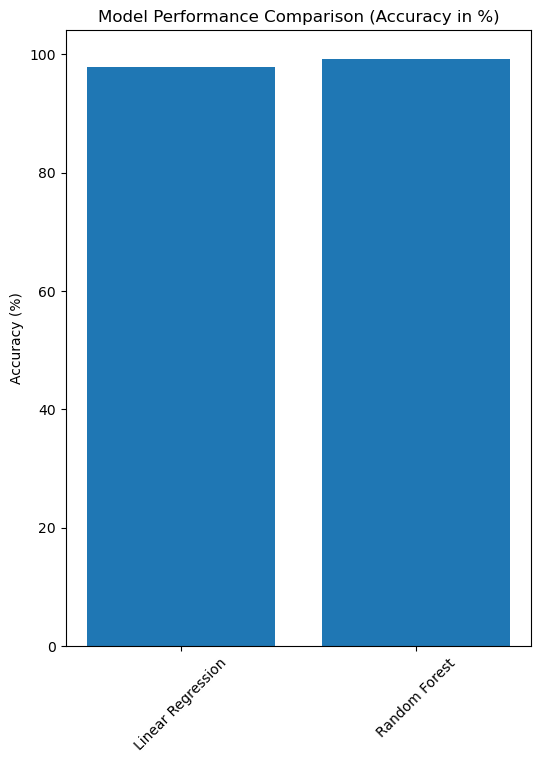

In [10]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor()
}

model_performance = {}
feature_importance = {}

# Train the models and find the accuracy of each of the models and store it's performance details to a data frame
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    accuracy = r2 * 100  # Convert R2 score to percentage
    
    model_performance[model_name] = {'MSE': mse, 'Accuracy (%)': accuracy}

    # Extract feature importance if supported
    if hasattr(model, 'coef_'):  # For Linear Regression
        feature_importance[model_name] = model.coef_
    elif hasattr(model, 'feature_importances_'):  # For Tree-based Models
        feature_importance[model_name] = model.feature_importances_
    else:
        feature_importance[model_name] = "Not Available"

# Convert performance to DataFrame
performance_df = pd.DataFrame(model_performance).T.reset_index()
performance_df.columns = ['Model', 'MSE', 'Accuracy (%)']

plt.figure(figsize=(6, 8))
plt.bar(performance_df['Model'], performance_df['Accuracy (%)'])
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison (Accuracy in %)')
plt.xticks(rotation=45)
plt.show()